# VGG Training

In [1]:
import tarfile
from scipy.io import loadmat
import pandas as pd
import os
import shutil
import torch
from torchvision.datasets import ImageFolder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

## Data Formatting

Extracting Train, Test and Validation with Labels

In [2]:
## Extract from tar file
# import tarfile
# file = tarfile.open("102segmentations.tgz")
# file.extractall('102flowersSegmentations')
# file.close()

## Load mat files
imagelabels = loadmat('imagelabels.mat')
# print(imagelabels)

setid = loadmat('setid.mat')
# print(setid)

## Generate labels df
df_labels = pd.DataFrame(imagelabels['labels'])
df_labels = df_labels.T
df_labels['image_id'] = df_labels.index +1 # rename the column such that it is image_id and labels
df_labels.set_index('image_id', inplace=True) # drop index by making image_id as index
df_labels.columns = ['labels'] # rename the column such that it is image_id and labels

# Generate train, test, validation df
df_setid_trnid = pd.DataFrame(setid['trnid'])
df_setid_valid = pd.DataFrame(setid['valid'])
df_setid_tstid = pd.DataFrame(setid['tstid'])

# Transpose the dataframes
df_setid_trnid = df_setid_trnid.T
df_setid_valid = df_setid_valid.T
df_setid_tstid = df_setid_tstid.T

## DEBUG
# print(df_setid_trnid.shape)
# print(df_setid_valid.shape)
# print(df_setid_tstid.shape)

# Create images df
image_folder = '102flowersSegmentations/segmim'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
df_images = pd.DataFrame(image_files, columns=['image_filename'])
df_images['image_id'] = df_images['image_filename'].str.extract(r'(\d+)').astype(int)

# Merge the dataframes
df_image_labels = df_images.merge(df_labels, on='image_id', how='left') # merge images and labels




Split into datasets

In [3]:
# train, validation and test split
for id in df_setid_trnid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'train'

for id in df_setid_valid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'valid'

for id in df_setid_tstid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'test'

# df_image_labels['set'].value_counts() # DEBUG

df_image_labels.to_csv('image_labels.csv', index=False) # save the dataframe to csv

## Sort into classes
num_classes = df_image_labels['labels'].nunique()
print("Number of classes: ", num_classes)
df_train_distribution = df_image_labels['labels'].value_counts().reset_index() # put information in a df
df_train_distribution.columns = ['class', 'count']
df_train_distribution = df_train_distribution.sort_values('count', ascending=False) # sort by class from 1 to 102

## create a folder for each class
# comment out if the folder already exists

# Create a new directory to store the class folders 
# os.makedirs('102flowers_segmen_split')

# Create a new directory to store the class folders 
# os.makedirs('102flowers_segmen_split/train')
# os.makedirs('102flowers_segmen_split/valid')
# os.makedirs('102flowers_segmen_split/test')

# split based on set in the csv
# for index, row in df_image_labels.iterrows():
#     image_filename = row['image_filename']
#     label = row['labels']
#     set = row['set']
#     src = os.path.join('102flowersSegmentations/segmim', image_filename)
#     dst = os.path.join('102flowers_segmen_split', set, str(label))
#     os.makedirs(dst, exist_ok=True)
#     shutil.copy(src, dst)



Number of classes:  102


In [4]:
# check if cuda is available
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


train_folder = '102flowers_segmen_split/train'
valid_folder = '102flowers_segmen_split/valid'
test_folder = '102flowers_segmen_split/test'

# create datasets
train_dataset = ImageFolder(train_folder) 
valid_dataset = ImageFolder(valid_folder)
test_dataset = ImageFolder(test_folder)

True
cuda


In [5]:
# create data generators
train_datagen = ImageDataGenerator( # create a data generator for data augmentation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255) # rescale the images

test_datagen = ImageDataGenerator(rescale=1./255)

# Define the transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create train and validation datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='102flowers_segmen_split/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='102flowers_segmen_split/valid', transform=valid_transforms)

# Create dataloaders for train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Update dataloaders in a dictionary
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

# Update dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset)
}


## Mixup
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


## Model Training

### VGG16

In [9]:
vgg16 = models.vgg16(pretrained=True) # Load the pre-trained VGG16 model

num_features = vgg16.classifier[6].in_features  # Modify the classifier to have 102 output classes
vgg16.classifier[6] = nn.Linear(num_features, 102)  # Replace final layer with 102 output classes

vgg16 = vgg16.to(device) # Move the model to the device (GPU or CPU)



c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train model function

In [6]:

def train_model(model, criterion, optimizer, scheduler, num_epochs, patience):
    start = time.time()

    early_stopping = EarlyStopping(patience=patience, delta=0)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    accuracy_history = {'train': [], 'valid': []}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Apply mixup in the training phase only
                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)
                    outputs = model(inputs)
                    loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Calculate loss with mixup
                    if phase == 'train':
                        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                    else:
                        loss = criterion(outputs, labels)  # Normal loss in validation

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss
                running_loss += loss.item() * inputs.size(0)

                # Calculate correct predictions differently based on phase
                if phase == 'train':
                    running_corrects += (lam * preds.eq(labels_a).sum().float() + (1 - lam) * preds.eq(labels_b).sum().float()).item()
                else:
                    running_corrects += (preds == labels).sum().item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            accuracy_history[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping check in the validation phase
            if phase == 'valid':
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    model.load_state_dict(early_stopping.get_best_model_weights())
                    return model, accuracy_history

        print()


    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, accuracy_history


early stopping class

In [7]:
# define early stopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss  # We use -val_loss because we want to minimize loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

    def get_best_model_weights(self):
        return self.best_model_wts

load model

In [8]:
def load_vgg16(num_frozen_layers):
    vgg16 = models.vgg16(pretrained=True)
    
    # Freeze layers
    layers_to_freeze = list(vgg16.features.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for 102 classes
    num_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = nn.Linear(num_features, 102)
    return vgg16.to(device)

In [10]:
num_epochs = 30
validation_accuracies = {}


for num_frozen_layers in range(7,15):
    print(f"\nTraining with {num_frozen_layers} frozen layers...")
    
    # Load model with the specified number of frozen layers
    model = load_vgg16(num_frozen_layers)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)
    
    # Define the learning rate scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)
    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])
    validation_accuracies[num_frozen_layers] = best_valid_acc

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")



Training with 7 frozen layers...
Epoch 0/29
----------
train Loss: 4.6579 Acc: 0.0151
valid Loss: 4.5626 Acc: 0.0431

Epoch 1/29
----------
train Loss: 4.5589 Acc: 0.0368
valid Loss: 4.3095 Acc: 0.0794

Epoch 2/29
----------
train Loss: 4.3206 Acc: 0.0735
valid Loss: 3.3646 Acc: 0.2480

Epoch 3/29
----------
train Loss: 3.9513 Acc: 0.1441
valid Loss: 2.9610 Acc: 0.3157

Epoch 4/29
----------
train Loss: 3.6392 Acc: 0.2139
valid Loss: 2.3225 Acc: 0.4500

Epoch 5/29
----------
train Loss: 3.3136 Acc: 0.2639
valid Loss: 1.8948 Acc: 0.5569

Epoch 6/29
----------
train Loss: 3.3318 Acc: 0.2895
valid Loss: 2.0859 Acc: 0.5461

Epoch 7/29
----------
train Loss: 3.0856 Acc: 0.3514
valid Loss: 1.5656 Acc: 0.6245

Epoch 8/29
----------
train Loss: 2.7270 Acc: 0.4154
valid Loss: 1.4182 Acc: 0.6441

Epoch 9/29
----------
train Loss: 2.8157 Acc: 0.4194
valid Loss: 1.4363 Acc: 0.6343

Epoch 10/29
----------
train Loss: 2.8263 Acc: 0.4147
valid Loss: 1.3848 Acc: 0.6529

Epoch 11/29
----------
train L

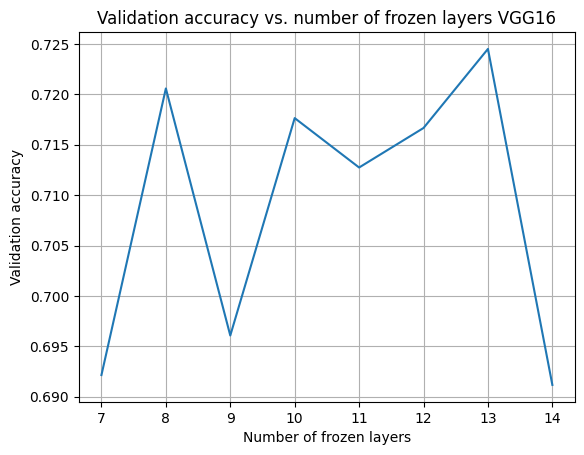

In [17]:
# plot the validation accuracies
plt.plot(list(validation_accuracies.keys()), list(validation_accuracies.values()))
plt.xlabel('Number of frozen layers')
plt.ylabel('Validation accuracy')
plt.grid()
plt.title('Validation accuracy vs. number of frozen layers VGG16')
plt.show()

### VGG19

In [11]:
def load_vgg19(num_frozen_layers):
    vgg19 = models.vgg19(pretrained=True)
    
    # Freeze layers
    layers_to_freeze = list(vgg19.features.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = False
    
    # Modify the final fully connected layer for 102 classes
    num_features = vgg19.classifier[6].in_features
    vgg19.classifier[6] = nn.Linear(num_features, 102)
    return vgg19.to(device)





In [ ]:
# Load VGG19 with specified number of frozen layers
validation_accuracies_vgg19 = {}
for num_frozen_layers in range(12,18):

    model = load_vgg19(num_frozen_layers)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)
    
    # Define the learning rate scheduler
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train the model
    model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)
    # Get the best validation accuracy for this configuration
    best_valid_acc = max(accuracy_history['valid'])
    validation_accuracies_vgg19[num_frozen_layers] = best_valid_acc

    print(f"Best validation accuracy with {num_frozen_layers} frozen layers: {best_valid_acc:.4f}")




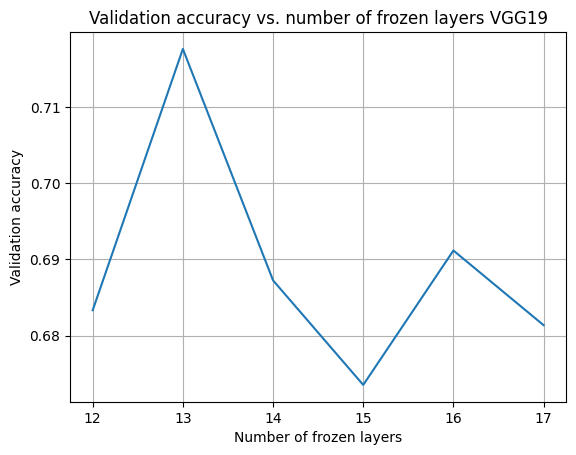

In [16]:
#plot the validation accuracies
plt.plot(list(validation_accuracies_vgg19.keys()), list(validation_accuracies_vgg19.values()))
plt.xlabel('Number of frozen layers')
plt.ylabel('Validation accuracy')
plt.grid()
plt.title('Validation accuracy vs. number of frozen layers VGG19')
plt.show()


In [12]:
# save model with 8 frozen layers

model = load_vgg16(8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)

torch.save(model.state_dict(), 'model_vgg16(8).pth')


Epoch 0/29
----------
train Loss: 4.6677 Acc: 0.0112
valid Loss: 4.5409 Acc: 0.0500

Epoch 1/29
----------
train Loss: 4.5426 Acc: 0.0380
valid Loss: 4.1274 Acc: 0.0941

Epoch 2/29
----------
train Loss: 4.2066 Acc: 0.0784
valid Loss: 3.0940 Acc: 0.2863

Epoch 3/29
----------
train Loss: 3.7557 Acc: 0.1652
valid Loss: 2.6915 Acc: 0.3755

Epoch 4/29
----------
train Loss: 3.5891 Acc: 0.2354
valid Loss: 2.0272 Acc: 0.5275

Epoch 5/29
----------
train Loss: 3.2678 Acc: 0.2851
valid Loss: 2.2380 Acc: 0.4490

Epoch 6/29
----------
train Loss: 3.1941 Acc: 0.3005
valid Loss: 1.8520 Acc: 0.5745

Epoch 7/29
----------
train Loss: 3.0247 Acc: 0.3426
valid Loss: 1.5537 Acc: 0.6265

Epoch 8/29
----------
train Loss: 2.9134 Acc: 0.3731
valid Loss: 1.5245 Acc: 0.6196

Epoch 9/29
----------
train Loss: 2.7238 Acc: 0.4097
valid Loss: 1.2667 Acc: 0.6892

Epoch 10/29
----------
train Loss: 2.8561 Acc: 0.3919
valid Loss: 1.2107 Acc: 0.6941

Epoch 11/29
----------
train Loss: 2.7117 Acc: 0.4394
valid Loss

In [13]:
# save model with 14 frozen layers

model = load_vgg19(13)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)

model, accuracy_history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)

torch.save(model.state_dict(), 'model_vgg19(13).pth')




Epoch 0/29
----------
train Loss: 4.6555 Acc: 0.0098
valid Loss: 4.5663 Acc: 0.0441

Epoch 1/29
----------
train Loss: 4.5395 Acc: 0.0379
valid Loss: 4.1564 Acc: 0.1010

Epoch 2/29
----------
train Loss: 4.1855 Acc: 0.0943
valid Loss: 3.0923 Acc: 0.2843

Epoch 3/29
----------
train Loss: 3.9031 Acc: 0.1430
valid Loss: 2.5165 Acc: 0.4020

Epoch 4/29
----------
train Loss: 3.5804 Acc: 0.2086
valid Loss: 2.2044 Acc: 0.4804

Epoch 5/29
----------
train Loss: 3.4446 Acc: 0.2548
valid Loss: 1.8813 Acc: 0.5265

Epoch 6/29
----------
train Loss: 3.1646 Acc: 0.3109
valid Loss: 1.7381 Acc: 0.5735

Epoch 7/29
----------
train Loss: 3.0355 Acc: 0.3486
valid Loss: 1.6122 Acc: 0.6098

Epoch 8/29
----------
train Loss: 2.9367 Acc: 0.3631
valid Loss: 1.6525 Acc: 0.5971

Epoch 9/29
----------
train Loss: 2.9756 Acc: 0.3530
valid Loss: 1.3239 Acc: 0.6686

Epoch 10/29
----------
train Loss: 2.8778 Acc: 0.3963
valid Loss: 1.2589 Acc: 0.6941

Epoch 11/29
----------
train Loss: 2.6726 Acc: 0.4423
valid Loss

## Testing

In [14]:
# Test Data

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])

# Load the test dataset
test_folder = '102flowers_segmen_split/test'
test_dataset = ImageFolder(test_folder, transform=test_transforms)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
# Load the model
vgg_16 = models.vgg16(pretrained=False)
num_features = vgg_16.classifier[6].in_features
vgg_16.classifier[6] = nn.Linear(num_features, 102)
vgg_16.load_state_dict(torch.load('model_vgg16(8).pth'))

# Move the model to the device
vgg_16 = vgg_16.to(device)

# Set the model to evaluation mode
vgg_16.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vgg_16(inputs)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

vgg16_accuracy = correct / total * 100
print(f'Accuracy of the network on the test images: {vgg16_accuracy:.4f}')



Accuracy of the network on the test images: 73.2314


In [20]:
vgg_19 = models.vgg19(pretrained=False)
num_features = vgg_19.classifier[6].in_features
vgg_19.classifier[6] = nn.Linear(num_features, 102)
vgg_19.load_state_dict(torch.load('model_vgg19(13).pth'))

# Move the model to the device
vgg_19 = vgg_19.to(device)

# Set the model to evaluation mode
vgg_19.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vgg_19(inputs)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

vgg19_accuracy = correct / total * 100
print(f'Accuracy of the network on the test images: {vgg19_accuracy:.4f}')

Accuracy of the network on the test images: 71.0522
